In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro

from sklearn.pipeline import Pipeline
import os
import random as python_random

from imblearn.over_sampling import SMOTE

import tensorflow as tf

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

import warnings
warnings.filterwarnings('ignore')


In [ ]:
seed = 345

# Set random seed for numpy
np.random.seed(seed)

# Set random seed for python
python_random.seed(seed)

# Set random seed for tensorflow
tf.random.set_seed(seed)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/

path_data = "/content/drive/MyDrive/Chapter 2/"

Mounted at /content/drive
MyDrive


## First Dataset NF_BoT_IoT

In [ ]:
df_NF_BoT_IoT = pd.read_parquet(path_data + "NF-BoT-IoT.parquet")
df_NF_BoT_IoT

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,52670,53,17,5.212000,71,126,1,1,0,4294966,0,Benign
1,49160,4444,6,0.000000,217753000,199100,4521,4049,24,4176249,1,Theft
2,3456,80,17,0.000000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,80,8080,6,7.000000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,80,80,6,7.000000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
595371,80,80,6,7.000000,2330065,0,2523,0,0,4263037,0,Benign
595372,0,0,6,0.000000,1054423,0,1513,0,0,4263062,0,Benign
595373,365,565,17,0.000000,62422,0,1357,0,0,4263062,0,Benign
595374,50850,8883,6,222.177994,11300,1664,32,32,24,4264935,0,Benign


# 1. Automated Data Pre-Processing

---

## Automated Transformation/Encoding
Automatically identify and transform string/text features into numerical features to make the data more readable by ML models

In [ ]:
# Define the automated data encoding function
def Auto_Encoding(df_NF_BoT_IoT):
    cat_features=[x for x in df_NF_BoT_IoT.columns if df_NF_BoT_IoT[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df_NF_BoT_IoT.columns:
            i = df_NF_BoT_IoT.columns.get_loc(col)
            # Transform to numerical features
            df_NF_BoT_IoT.iloc[:,i] = df_NF_BoT_IoT.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df_NF_BoT_IoT


In [ ]:
df_NF_BoT_IoT_ = Auto_Encoding(df_NF_BoT_IoT)

In [ ]:
df_NF_BoT_IoT_.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,52670,53,17,5.212,71,126,1,1,0,4294966,0,19234
1,49160,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,16954
2,3456,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,5949
3,80,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,25724
4,80,80,6,7.000,8374706,0,9086,0,0,4175916,0,25724


## Automated Imputation
Detect and impute missing values to improve data quality

In [ ]:
# Define the automated data imputation function
def Auto_Imputation(df_NF_BoT_IoT):
    if df_NF_BoT_IoT.isnull().values.any() or np.isinf(df_NF_BoT_IoT).values.any(): # if there is any empty or infinite values
        df_NF_BoT_IoT.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_NF_BoT_IoT.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df_NF_BoT_IoT

In [ ]:
df_NF_BoT_IoT_ = Auto_Imputation(df_NF_BoT_IoT_)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [ ]:
def Auto_Normalization(df_NF_BoT_IoT):
    stat, p = shapiro(df_NF_BoT_IoT)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df_NF_BoT_IoT.drop(['Label'],axis = 1).dtypes[df_NF_BoT_IoT.dtypes != 'object'].index
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df_NF_BoT_IoT[numeric_features] = df_NF_BoT_IoT[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df_NF_BoT_IoT[numeric_features] = df_NF_BoT_IoT[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df_NF_BoT_IoT

In [ ]:
df_NF_BoT_IoT_ = Auto_Normalization(df_NF_BoT_IoT_)

Statistics=0.270, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


In [ ]:
df_NF_BoT_IoT_.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,0.803693,0.000809,1.0000,0.021361,1.884118e-07,5.180502e-07,0.000000,0.000016,0.00000,1.000000,0,0.741566
1,0.750134,0.067811,0.3125,0.000000,9.541218e-01,8.186015e-04,0.119526,0.066258,0.11215,0.972359,1,0.653661
2,0.052735,0.001221,1.0000,0.000000,3.727922e-02,3.666797e-02,0.240242,0.148683,0.00000,0.972281,0,0.229363
3,0.001221,0.123293,0.3125,0.028689,3.699055e-02,3.705870e-02,0.240242,0.148683,0.00000,0.972281,0,0.991788
4,0.001221,0.001221,0.3125,0.028689,3.669508e-02,0.000000e+00,0.240242,0.000000,0.00000,0.972281,0,0.991788


## Train-test split
Split the dataset into the training and the test set

In [ ]:
X_NF_BoT_IoT = df_NF_BoT_IoT_.drop(['Label'],axis=1)
y_NF_BoT_IoT = df_NF_BoT_IoT_['Label']

# Here we used the 80%/20% split, it can be changed based on specific tasks
X_train_NF_BoT_IoT, X_test_NF_BoT_IoT, y_train_NF_BoT_IoT, y_test_NF_BoT_IoT = train_test_split(X_NF_BoT_IoT, y_NF_BoT_IoT, train_size = 0.8, test_size = 0.2,random_state = 0)

## Automated data balancing
Generate minority class samples to solve class-imbalance and improve data quality.  
Synthetic Minority Over-sampling Technique (SMOTE) method is used.

In [ ]:
pd.Series(y_train_NF_BoT_IoT).value_counts()

1    465203
0     11097
Name: Label, dtype: int64

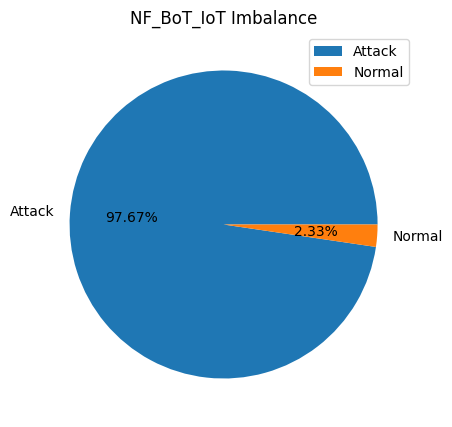

In [ ]:
plt.figure(figsize=(6,5))
plt.pie(pd.Series(y_train_NF_BoT_IoT).value_counts(),labels=["Attack", "Normal"],autopct='%0.2f%%')
plt.title("NF_BoT_IoT Imbalance")
plt.legend()
plt.show()

In [ ]:
# For binary data (can be modified for multi-class data with the same logic)
def Auto_Balancing(X_train_NF_BoT_IoT, y_train_NF_BoT_IoT):
    number0 = pd.Series(y_train_NF_BoT_IoT).value_counts().iloc[0]
    number1 = pd.Series(y_train_NF_BoT_IoT).value_counts().iloc[1]

    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1

    # evaluate whether the incoming dataset is imbalanced (the abnormal/normal ratio is smaller than a threshold (e.g., 50%))
    if (number1/number0 > 1.5) or (number0/number1 > 1.5):
        smote=SMOTE(n_jobs=-1,sampling_strategy={0:nlarge, 1:nlarge})
        X_train_NF_BoT_IoT, y_train_NF_BoT_IoT = smote.fit_resample(X_train_NF_BoT_IoT, y_train_NF_BoT_IoT)

    return X_train_NF_BoT_IoT, y_train_NF_BoT_IoT

In [ ]:
X_train_NF_BoT_IoT, y_train_NF_BoT_IoT = Auto_Balancing(X_train_NF_BoT_IoT, y_train_NF_BoT_IoT)

In [ ]:
pd.Series(y_train_NF_BoT_IoT).value_counts()

1    465203
0    465203
Name: Label, dtype: int64

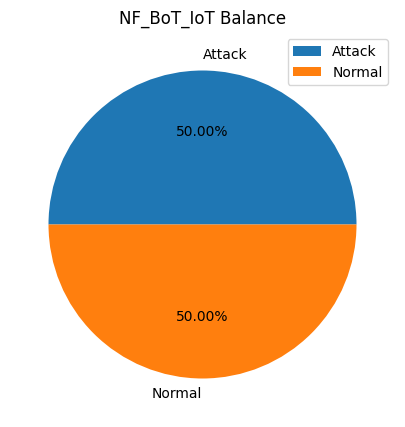

In [ ]:
plt.figure(figsize=(6,5))
plt.pie(pd.Series(y_train_NF_BoT_IoT).value_counts(),labels=["Attack", "Normal"],autopct='%0.2f%%')
plt.title("NF_BoT_IoT Balance")
plt.legend()
plt.show()

# Second Dataset IoTID20

In [ ]:
df_IoTID20 = pd.read_csv(path_data + "IoT_2020_b_0.01.csv")
df_IoTID20

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Flow_Duration,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Bwd_Pkt_Len_Max,...,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Std,FIN_Flag_Cnt,Pkt_Size_Avg,Init_Bwd_Win_Byts,Idle_Mean,Idle_Max,Idle_Min,Label
0,12708,25886,53190,200,9020,3760,124,0.0,2776.0,1388.0,...,0.00,16129.03,0.00,0,2082.0,1869,124.00,124.0,124.0,1
1,60,25883,60357,110,7760,3649,46189,2528.0,0.0,0.0,...,43.30,43.30,698.97,0,632.0,126,15396.33,40225.0,1910.0,1
2,12695,25883,9020,203,52739,2261,73,1388.0,1388.0,1388.0,...,13698.63,13698.63,0.00,0,2082.0,1869,73.00,73.0,73.0,1
3,12690,25886,52717,200,9020,1963,149,0.0,0.0,0.0,...,13422.82,6711.41,0.00,0,0.0,32679,74.50,75.0,74.0,1
4,12690,25886,52717,200,9020,1905,83,0.0,0.0,0.0,...,12048.19,12048.19,0.00,0,0.0,32422,83.00,83.0,83.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,12659,25886,10125,200,9020,1057,70,0.0,2776.0,1388.0,...,0.00,28571.43,0.00,0,2082.0,1869,70.00,70.0,70.0,1
6248,13708,25883,60158,233,8899,3264,40,128.0,32.0,32.0,...,100000.00,25000.00,0.00,0,38.4,-1,10.00,21.0,5.0,1
6249,7655,15614,8487,200,554,3697,1283,0.0,0.0,0.0,...,0.00,1558.85,0.00,0,0.0,14600,1283.00,1283.0,1283.0,1
6250,62696,25889,64783,233,9988,3192,222,96.0,32.0,32.0,...,13513.51,4504.50,0.00,0,40.0,-1,74.00,206.0,8.0,1


In [ ]:
df_IoTID20=Auto_Encoding(df_IoTID20)

In [ ]:
df_IoTID20=Auto_Imputation(df_IoTID20)

In [ ]:
df_IoTID20=Auto_Normalization(df_IoTID20)

Statistics=0.108, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


In [ ]:
X_IoTID20 = df_IoTID20.drop(['Label'],axis=1)
y_IoTID20 = df_IoTID20['Label']

# Here we used the 80%/20% split, it can be changed based on specific tasks
X_train_IoTID20, X_test_IoTID20, y_train_IoTID20, y_test_IoTID20 = train_test_split(X_IoTID20,y_IoTID20, train_size = 0.8, test_size = 0.2,random_state = 0)

In [ ]:
pd.Series(y_train_IoTID20).value_counts()

1    4717
0     284
Name: Label, dtype: int64

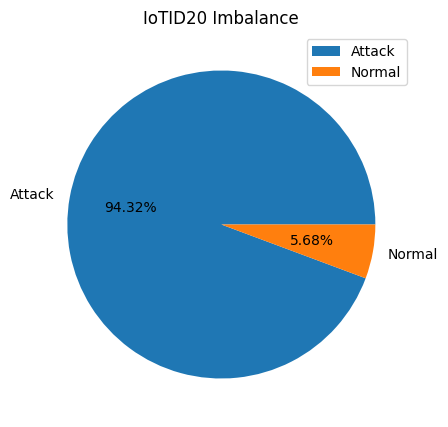

In [ ]:
plt.figure(figsize=(6,5))
plt.pie(pd.Series(y_train_IoTID20).value_counts(),labels=["Attack", "Normal"],autopct='%0.2f%%')
plt.title("IoTID20 Imbalance")
plt.legend()
plt.show()

In [ ]:
X_train_IoTID20, y_train_IoTID20 = Auto_Balancing(X_train_IoTID20, y_train_IoTID20)

In [ ]:
pd.Series(y_train_IoTID20).value_counts()

1    4717
0    4717
Name: Label, dtype: int64

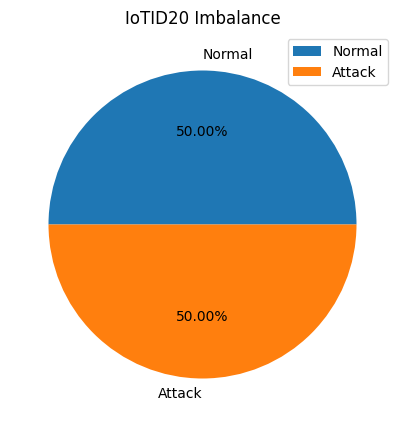

In [ ]:
plt.figure(figsize=(6,5))
plt.pie(pd.Series(y_train_IoTID20).value_counts(),labels=["Normal", "Attack"],autopct='%0.2f%%')
plt.title("IoTID20 Imbalance")
plt.legend()
plt.show()

## Machine Learning Models

NF_BoT_IoT is of CIC-IDS2017
IoTID20 is of IoT-IDS2020
As the data is divided into train and test (80-20)% respectively you are expected to take 10 or 20 percent from training data for validation purpose

In [ ]:
X_train_NF_BoT_IoT.shape, X_test_NF_BoT_IoT.shape, y_train_NF_BoT_IoT.shape, y_test_NF_BoT_IoT.shape

((930406, 11), (119076, 11), (930406,), (119076,))

In [ ]:
X_train_IoTID20.shape, X_test_IoTID20.shape, y_train_IoTID20.shape, y_test_IoTID20.shape

((9434, 31), (1251, 31), (9434,), (1251,))